<a href="https://colab.research.google.com/github/tedyadika/Azureml/blob/main/2_Data_eng_visuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Azure ML SDK modules

In [13]:
!pip install azureml.core
!pip install numpy
!pip install pycaret
!pip install azureml-dataset-runtime --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.1/31.1 MB 67.9 MB/s eta 0:00:00
  Attempting uninstall: msal-extensions
    Found existing installation: msal-extensions 1.0.0
    Uninstalling msal-extensions-1.0.0:
      Successfully uninstalled msal-extensions-1.0.0


In [1]:
from azureml.core import Workspace, Datastore,Dataset,Experiment,Run

### Import python modules

In [2]:
%matplotlib inline
import datetime
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date,timedelta
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import joblib
from pycaret.regression import *
#from lazypredict.Supervised import LazyRegressor

### Set up and data import 

In [3]:
ws = Workspace.get(name= 'dscglobalceedamlt',
                    subscription_id= '8b20e38c-72fb-4030-a702-128e713479ca',
                    resource_group= 'DSCGlobalCEEDTANLTst')

az_store= Datastore.get(ws,'datastore_sdk_blob1')
az_dataset= Dataset.get_by_name(ws,'country_sdk')
az_default_store = ws.get_default_datastore()

### set up experiment

In [4]:
experiment_run = Run.get_context()

In [5]:
dataset1 =az_dataset.to_pandas_dataframe()


Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'


In [6]:
df = dataset1.copy()
df = df.drop(['DCRPL','ECOMM','RETAIL'], axis=1)
df['logarithm_base2'] = np.log10(df['SUM_QTY_TOTAL_PICKS'])

In [7]:
nulldf = df.isnull().sum()
for col in df.columns:
    experiment_run.log(col, nulldf[col])

Attempted to log scalar metric DATE:
0
Attempted to log scalar metric ORDTYP_map:
0
Attempted to log scalar metric DAY_YEAR:
0
Attempted to log scalar metric day_of_week:
0
Attempted to log scalar metric COUNTRY_NAME:
0
Attempted to log scalar metric NBR_ORDERS:
0
Attempted to log scalar metric SUM_QTY_TOTAL_PICKS:
0
Attempted to log scalar metric SUM_QTY_PIECE_PICKS:
0
Attempted to log scalar metric Month:
0
Attempted to log scalar metric Year:
0
Attempted to log scalar metric WEEK_YEAR:
0
Attempted to log scalar metric DATE_N:
0
Attempted to log scalar metric logarithm_base2:
0


### ploting

<Figure size 720x216 with 0 Axes>

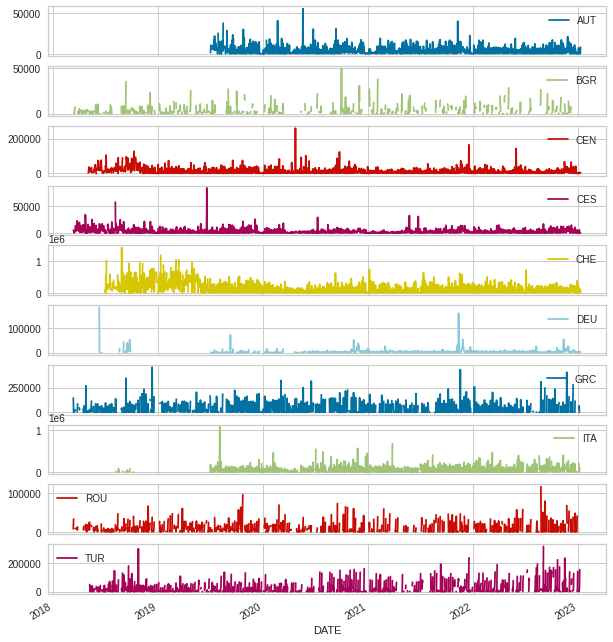

In [8]:
plt.figure(figsize=(10,3))   
pd.pivot_table(df.reset_index(),
               index='DATE', columns='COUNTRY_NAME', values='SUM_QTY_TOTAL_PICKS'
              ).plot(subplots=True,figsize=(10, 12))
           
plt.show()

### spliting our data by country 

In [9]:
# Initialize an empty list
df_list = []
# Split the dataframe into separate datasets based on the values in the 'country' column
for name, group in df.groupby('COUNTRY_NAME'):
  df_list.append(group)

# Print the list of dataframes
#print(df_list)


### Adding importang parameters to our data

In [10]:
def add_values(data):
    #data = df.copy()
    #data['logarithm_base2'] = np.log10(data['SUM_QTY_TOTAL_PICKS'])
    data.sort_values('DATE', inplace=True)
    data['DATE'] = pd.to_datetime(data['DATE'])
    data['MA18'] = data['logarithm_base2'].shift(35).rolling(2).mean()
    data['MA16'] = data['logarithm_base2'].shift(21).rolling(7).mean()
    data['Month'] = [i.month for i in data['DATE']]
    data['Year'] = [i.year for i in data['DATE']]
    data['WEEK_YEAR'] = data['DATE'].dt.isocalendar().week 
    data['day_of_week'] = data['DATE'].dt.dayofweek
    data['DAY_YEAR'] = data['DATE'].dt.dayofyear
    data['DATE_N'] = data['DATE'].apply(lambda x:x.toordinal())
    data["WEEK_YEAR"] = data["WEEK_YEAR"].astype('int64').astype('int64')
    #data = data.dropna()
    return(data)


for df in df_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)




### Adding Lags

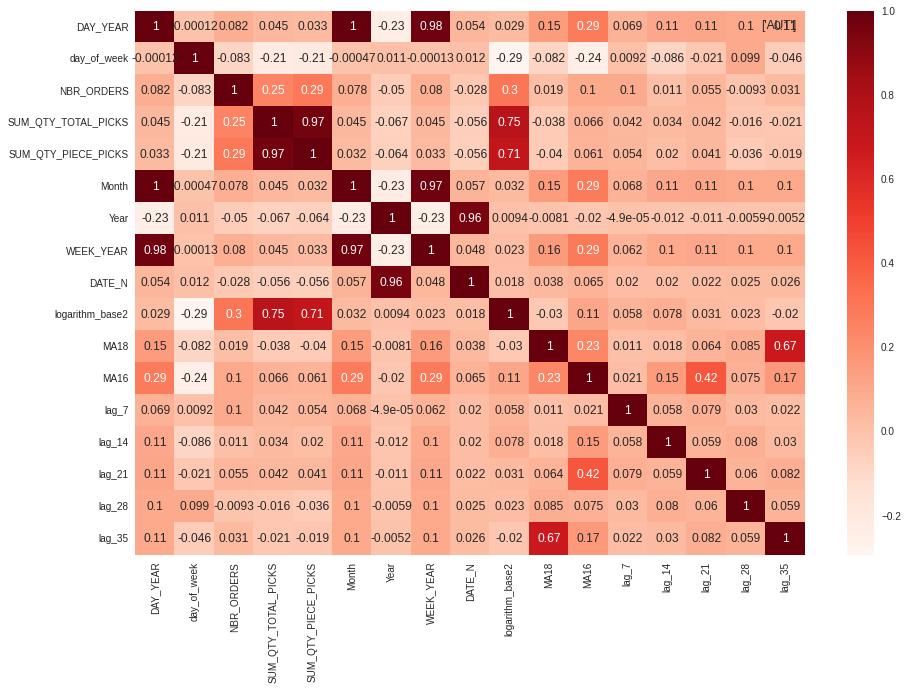

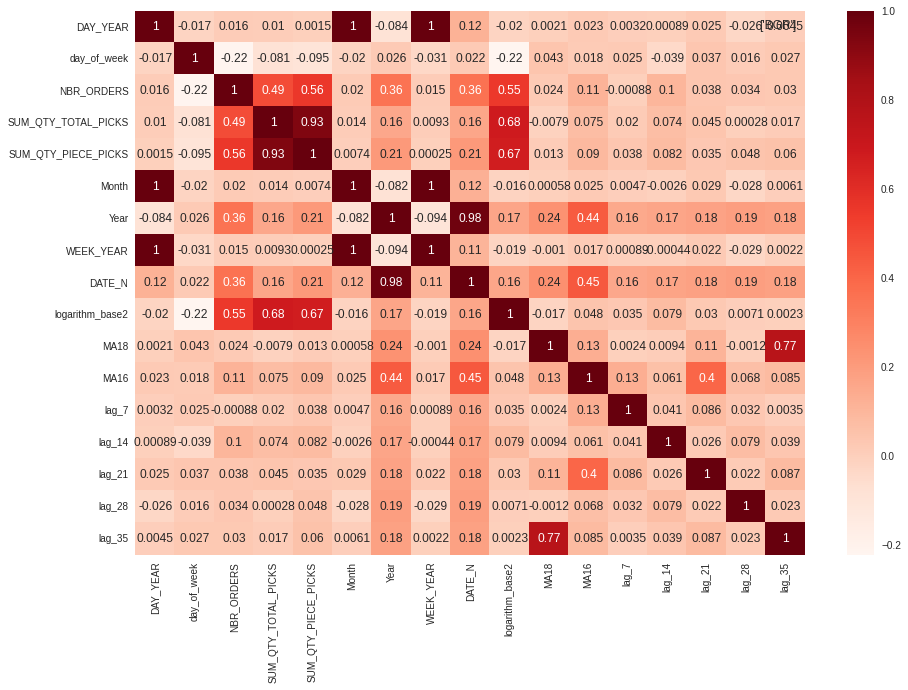

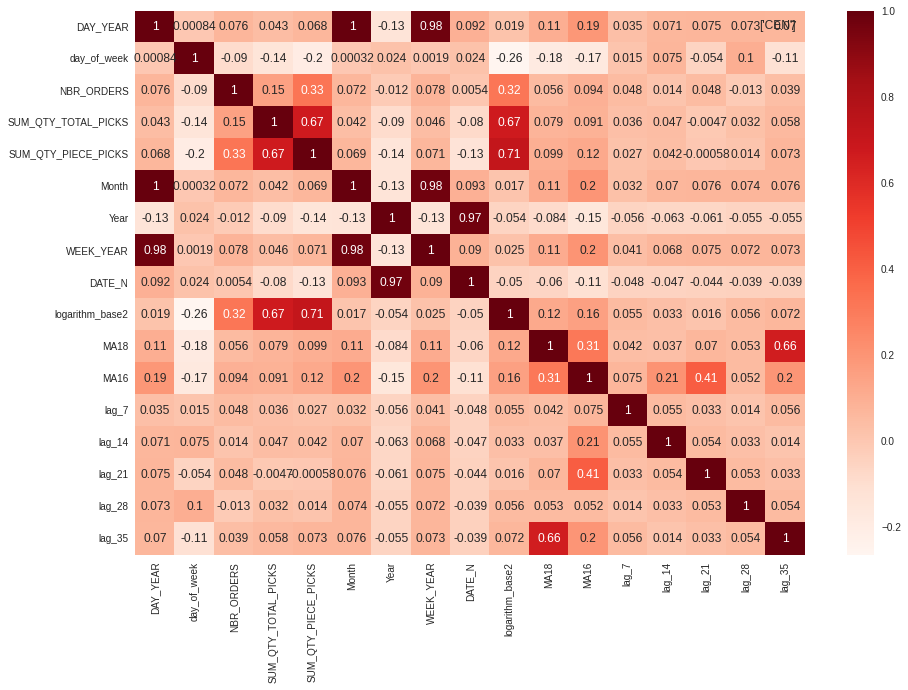

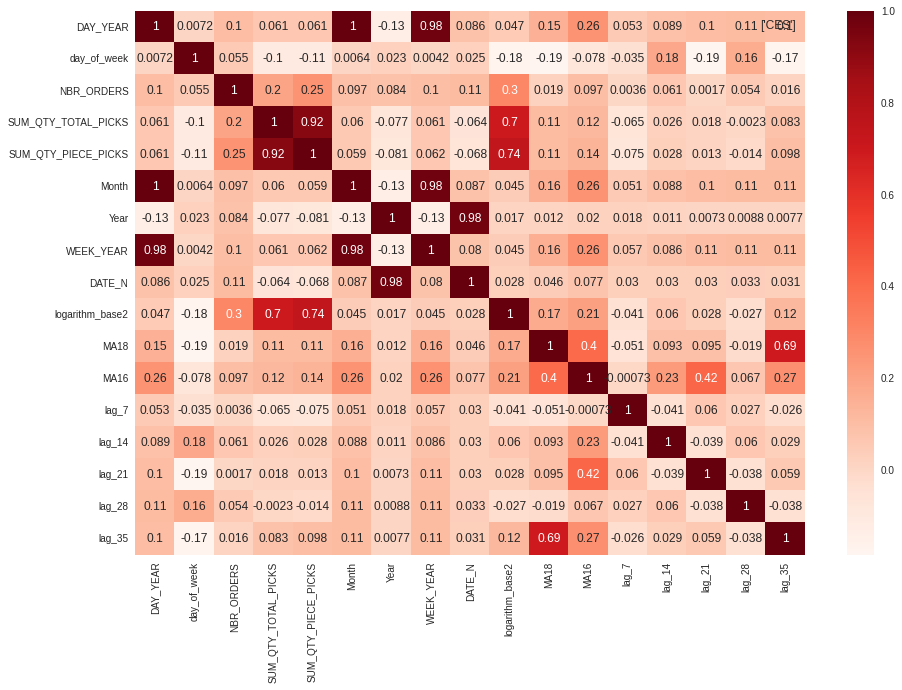

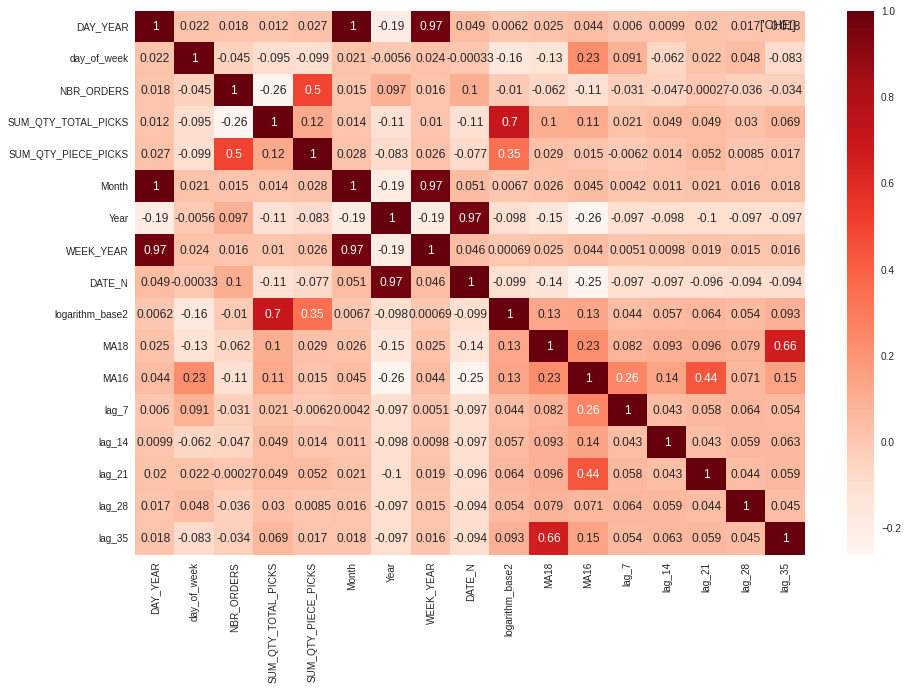

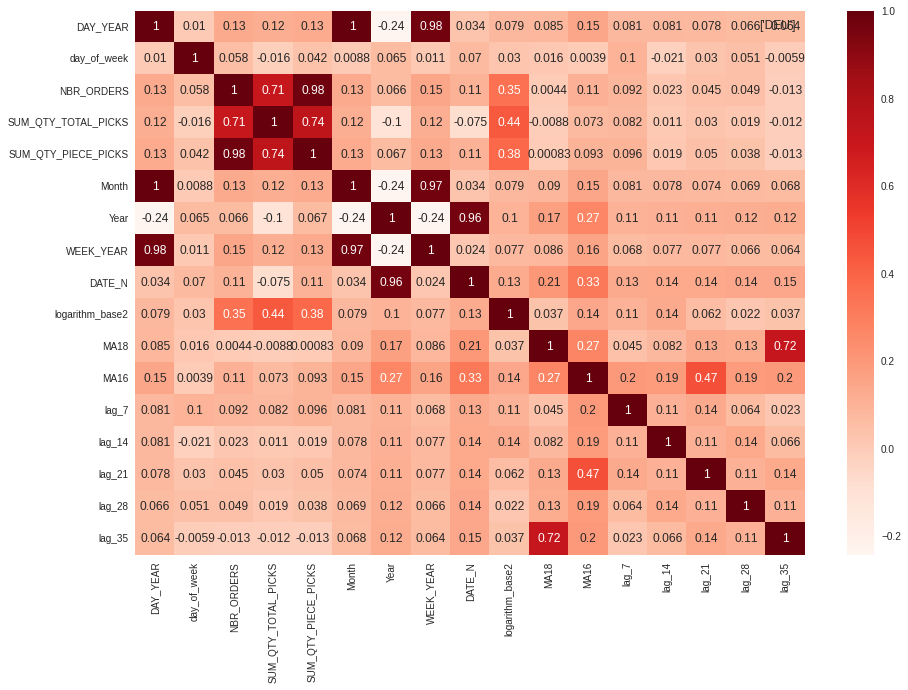

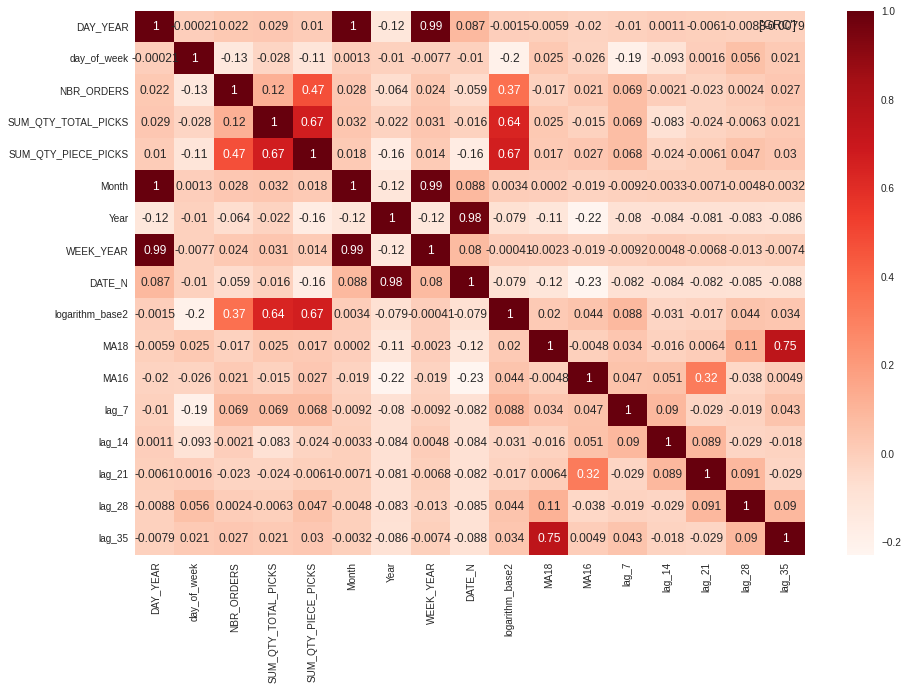

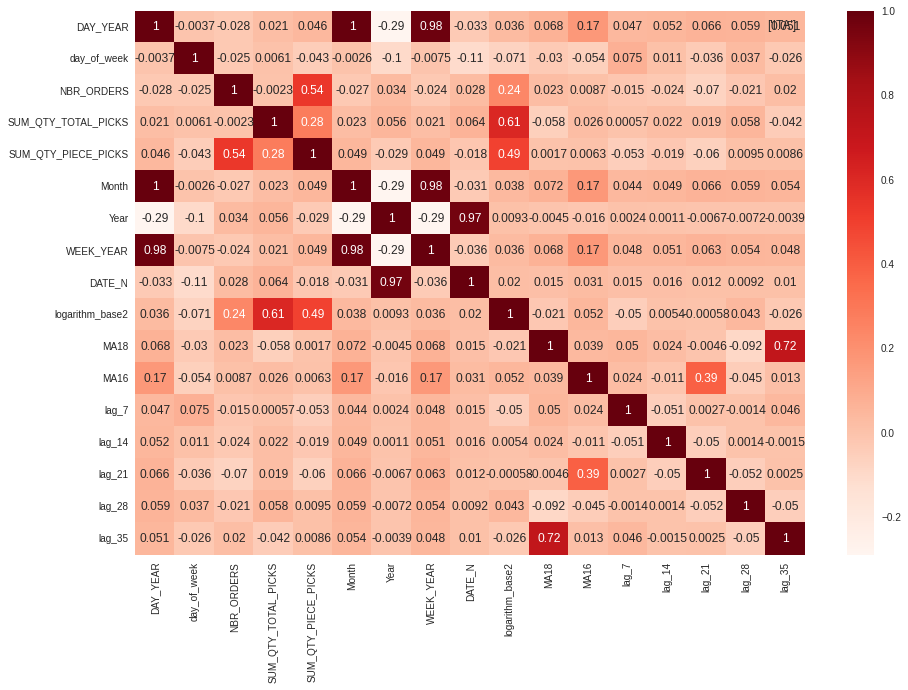

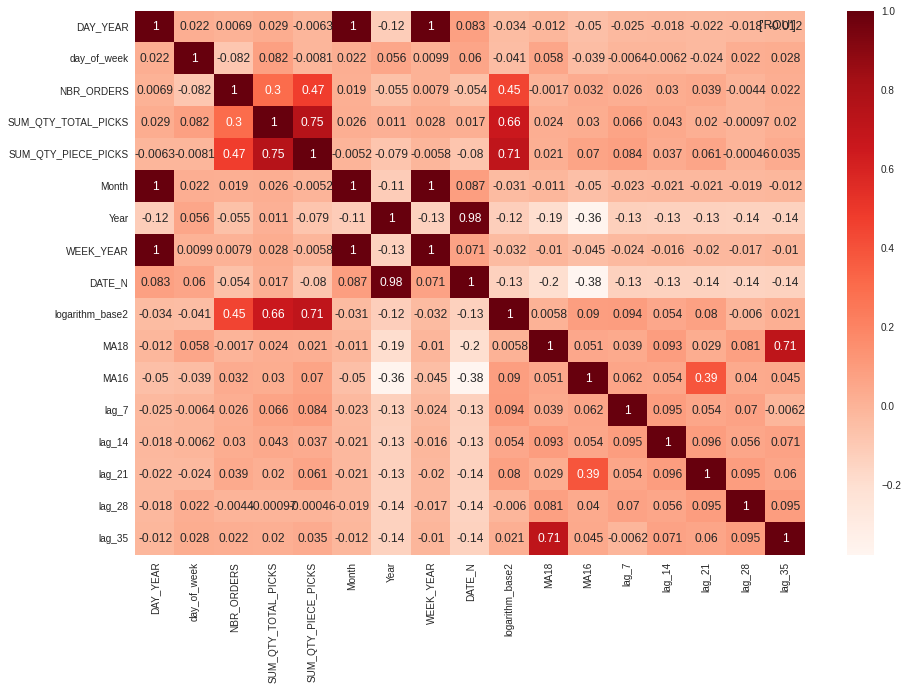

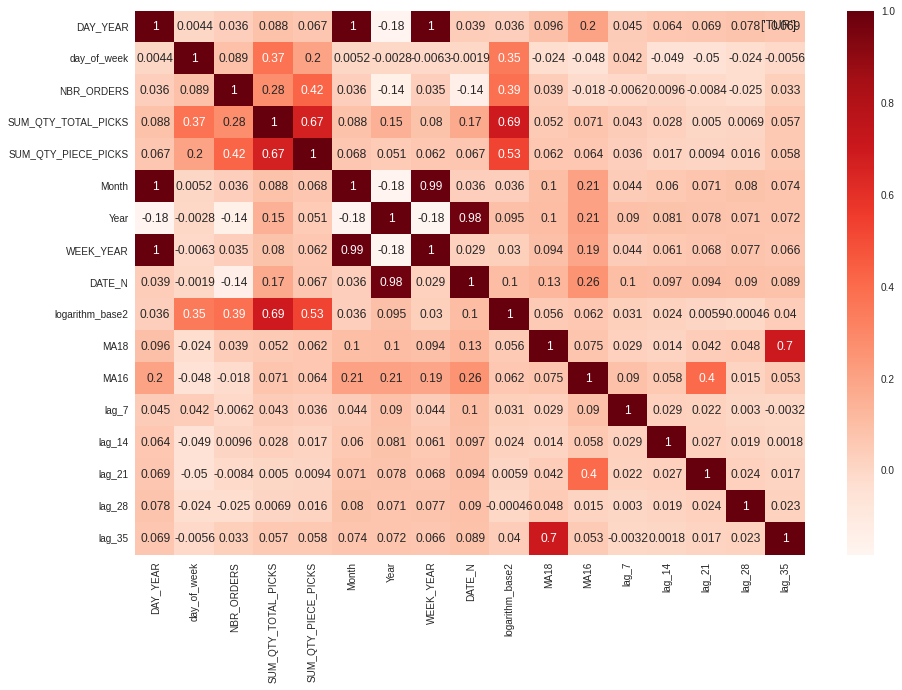

In [11]:
for df in df_list:
    label= df['COUNTRY_NAME'].unique()
    plt.figure(figsize=(15,10))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.legend(title = label)
    plt.show()

### AUSTRIA ML

In [ ]:
Aut_data = df_list[0].copy()
Aut_data = Aut_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)

### setting up our Algorithm

In [ ]:
s = setup(Aut_data, target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: regression
INFO:logs:version 2.3.10
INFO:logs:Initializing setup()
INFO:logs:setup(target=logarithm_base2, ml_usecase=regression, available_plots={'parameter': 'Hyperparameters', 'residuals': 'Residuals', 'error': 'Prediction Error', 'cooks': 'Cooks Distance', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'vc': 'Validation Curve', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'tree': 'Decision Tree', 'residuals_interactive': 'Interactive Residuals'}, train_size=0.95, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_feature

### comparing and finding best model

In [ ]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,0.5680,4.434000e-01,0.6658,1.354000e-01,0.1657,0.1912,0.2133
rf,Random Forest Regressor,0.5729,4.478000e-01,0.6690,1.276000e-01,0.1671,0.1951,1.0733
omp,Orthogonal Matching Pursuit,0.5765,4.494000e-01,0.6703,1.234000e-01,0.1671,0.1938,0.0233
gbr,Gradient Boosting Regressor,0.5804,4.755000e-01,0.6894,7.210000e-02,0.1708,0.1935,0.3533
et,Extra Trees Regressor,0.5933,4.897000e-01,0.6988,4.360000e-02,0.1750,0.2035,0.6233
lightgbm,Light Gradient Boosting Machine,0.5882,4.991000e-01,0.7058,2.670000e-02,0.1759,0.1995,0.3633
huber,Huber Regressor,0.6177,5.214000e-01,0.7219,-1.560000e-02,0.1806,0.2106,0.0267
dummy,Dummy Regressor,0.6164,5.232000e-01,0.7232,-1.930000e-02,0.1805,0.2091,0.0200
llar,Lasso Least Angle Regression,0.6164,5.232000e-01,0.7232,-1.930000e-02,0.1805,0.2091,0.0200
ridge,Ridge Regression,0.6127,5.302000e-01,0.7257,-3.800000e-02,0.1830,0.2103,0.0200


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123)
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
evaluate_model(best)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

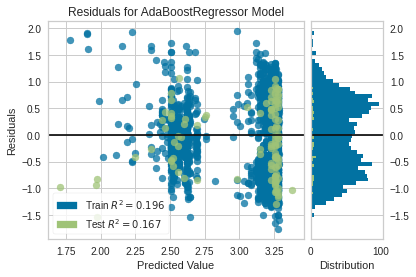

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(best, plot = 'residuals')

### ploting our best features 

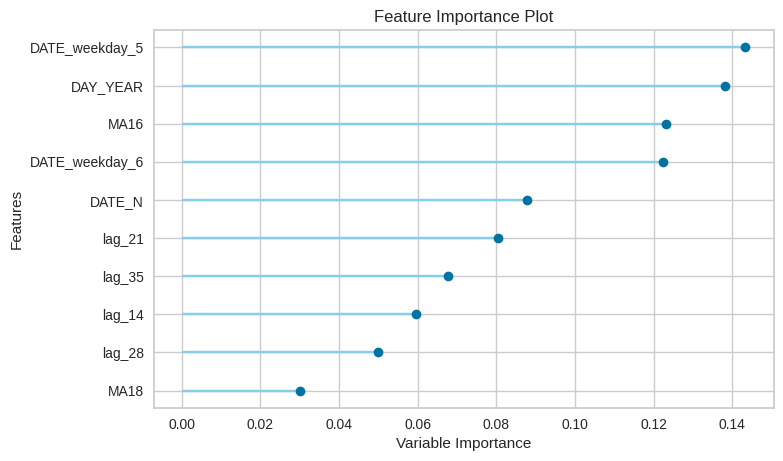

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(best, plot = 'feature')

In [ ]:
predict_model(best)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.56,0.4175,0.6461,0.1665,0.1587,0.1835


,DAY_YEAR,WEEK_YEAR,DATE_N,lag_7,lag_14,lag_21,lag_28,lag_35,MA18,MA16,...,DATE_month_6,DATE_month_8,DATE_weekday_1,DATE_weekday_2,DATE_weekday_5,DATE_weekday_6,DATE_is_month_end_0,DATE_is_month_start_0,logarithm_base2,Label
0,311.0,45.0,738466.0,4.528865,2.462398,2.478566,2.305351,2.472756,2.817362,3.124837,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.631444,3.262948
1,311.0,45.0,738466.0,2.440909,2.568202,4.276071,2.451787,3.593729,3.033243,3.385449,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.433450,3.276523
2,312.0,45.0,738467.0,3.786893,3.972989,2.562293,2.496930,3.895257,3.744493,3.394787,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.340246,3.276523
3,312.0,45.0,738467.0,2.428135,3.730944,3.682867,4.324344,2.394452,3.144854,3.303147,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.502427,3.276523
4,313.0,45.0,738468.0,1.000000,2.517196,2.399674,3.938420,4.247556,3.321004,3.083326,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.859138,3.259218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,7.0,1.0,738527.0,3.868586,2.977724,2.158362,3.444045,3.672190,3.210577,2.908071,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.724276,2.506759
110,7.0,1.0,738527.0,3.788027,2.906335,2.158362,2.376577,2.511883,3.092037,2.876898,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.627366,2.365514
111,8.0,1.0,738528.0,2.731589,2.673942,3.407561,3.815113,1.857332,2.184608,2.818676,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.578639,2.554809
112,9.0,2.0,738529.0,3.399154,1.505150,2.665581,4.025265,2.418301,2.137817,2.624435,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.205367,3.259218


### **Save the model** 

In [ ]:
save_model(best, 'AUT_model')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123), model_name=AUT_model, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['NBR_ORDERS',
                                                       'SUM_QTY_TOTAL_PICKS'],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='logarithm_base2',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None...
                ('scaling', 'passthr

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['NBR_ORDERS',
                                                        'SUM_QTY_TOTAL_PICKS'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='logarithm_base2',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None...
                 ('dummy', Dummify(target='logarithm_base2')),
                 ('fix_perfect', Remove_100(target='logarithm_base2')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fi

## loading saved model

In [ ]:
loaded_model = load_model('AUT_model')

INFO:logs:Initializing load_model()
INFO:logs:load_model(model_name=AUT_model, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


## creating future dataset

In [ ]:
prediction_df =[]

In [ ]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([Aut_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

In [ ]:
Aut_future = future_list[0].tail(10)
Aut_future = Aut_future.drop('logarithm_base2',axis = 1)
predictions_aut = predict_model(best, data=Aut_future)
predictions_aut['prediction'] = 10 ** predictions_aut['Label'] 
predictions_aut['COUNTRY_NAME'] ='AUT' 
prediction_df.append(predictions_aut)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,DATE,DAY_YEAR,day_of_week,COUNTRY_NAME,Month,Year,WEEK_YEAR,DATE_N,lag_7,lag_14,lag_21,lag_28,lag_35,MA18,MA16,Label,prediction
669,2022-11-30,334,2,AUT,11,2022,48,738489,1.397940,1.919078,2.243038,3.629919,3.790637,4.064208,3.417416,3.668415,4660.310861
670,2022-12-05,339,0,AUT,12,2022,49,738494,1.845098,2.980912,2.326336,3.634477,3.898561,3.844599,3.230539,3.116056,1306.338486
671,2022-12-06,340,1,AUT,12,2022,49,738495,2.324282,2.322219,1.770852,3.242541,3.631951,3.765256,3.020297,3.735790,5442.392958
672,2022-12-07,341,2,AUT,12,2022,49,738496,1.380211,0.778151,3.370883,3.607884,2.008600,2.820275,2.986440,3.671017,4688.320277
673,2023-01-10,10,1,AUT,1,2023,2,738530,2.462398,4.021148,4.052232,3.399674,2.184691,2.096646,3.079663,3.748802,5607.920183
674,2023-01-11,11,2,AUT,1,2023,2,738531,4.136467,3.917558,4.247335,3.913655,3.176959,2.680825,3.127331,3.684029,4830.912819
675,2023-01-12,12,3,AUT,1,2023,2,738532,3.049218,3.391817,2.382017,3.880642,4.156398,3.666678,2.913242,3.130183,1349.531287
676,2023-01-13,13,4,AUT,1,2023,2,738533,3.931000,1.397940,1.919078,2.243038,3.629919,3.893158,2.866962,3.130555,1350.687022
677,2023-01-14,14,5,AUT,1,2023,2,738534,3.111934,1.845098,2.980912,2.326336,3.634477,3.632198,2.960473,3.130926,1351.843746
678,2023-01-15,15,6,AUT,1,2023,2,738535,3.853881,2.324282,2.322219,1.770852,3.242541,3.438509,3.039239,3.131298,1353.001461


### **BGR ML**

In [ ]:
BGR_data = df_list[1].copy()
BGR_data = BGR_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)

### Setting up Algorithm 

In [ ]:
s = setup(BGR_data, target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: regression
INFO:logs:version 2.3.10
INFO:logs:Initializing setup()
INFO:logs:setup(target=logarithm_base2, ml_usecase=regression, available_plots={'parameter': 'Hyperparameters', 'residuals': 'Residuals', 'error': 'Prediction Error', 'cooks': 'Cooks Distance', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'vc': 'Validation Curve', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'tree': 'Decision Tree', 'residuals_interactive': 'Interactive Residuals'}, train_size=0.95, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_feature

### comparing models

In [ ]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,6.802000e-01,6.965000e-01,8.342000e-01,-8.700000e-03,0.2325,2.792000e-01,0.0300
huber,Huber Regressor,7.211000e-01,7.435000e-01,8.622000e-01,-7.070000e-02,0.2424,3.096000e-01,0.0267
lasso,Lasso Regression,6.939000e-01,7.504000e-01,8.657000e-01,-7.500000e-02,0.2474,3.203000e-01,0.0200
en,Elastic Net,6.939000e-01,7.533000e-01,8.673000e-01,-7.860000e-02,0.2480,3.214000e-01,0.0267
br,Bayesian Ridge,6.831000e-01,7.528000e-01,8.673000e-01,-8.130000e-02,0.2468,3.136000e-01,0.0233
dummy,Dummy Regressor,7.377000e-01,7.604000e-01,8.720000e-01,-9.700000e-02,0.2434,3.102000e-01,0.0200
llar,Lasso Least Angle Regression,7.377000e-01,7.604000e-01,8.720000e-01,-9.700000e-02,0.2434,3.102000e-01,0.0200
knn,K Neighbors Regressor,7.136000e-01,7.648000e-01,8.745000e-01,-1.049000e-01,0.2476,3.168000e-01,0.0333
ada,AdaBoost Regressor,7.246000e-01,7.756000e-01,8.795000e-01,-1.287000e-01,0.2447,2.975000e-01,0.1233
rf,Random Forest Regressor,7.156000e-01,7.835000e-01,8.837000e-01,-1.374000e-01,0.2462,2.943000e-01,0.4167


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None)
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
evaluate_model(best)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

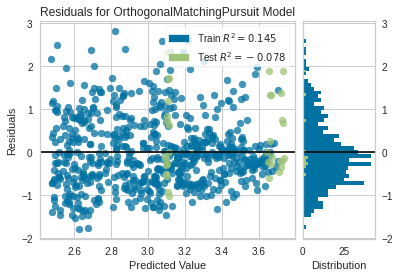

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(best, plot = 'residuals')

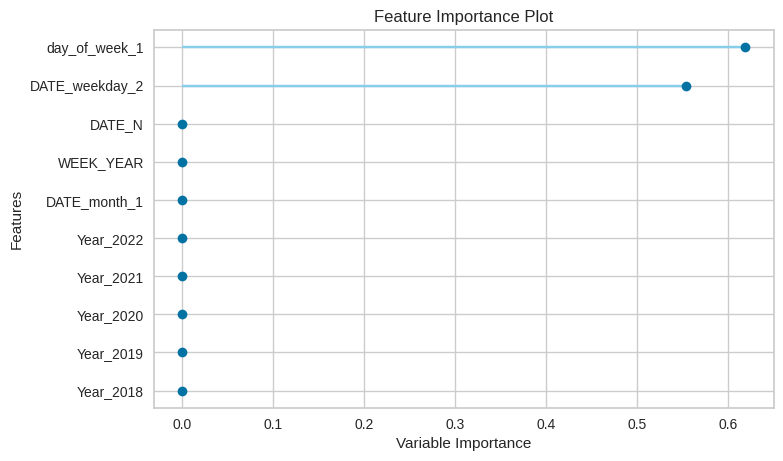

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(best, plot = 'feature')

###Save the model

In [ ]:
save_model(best, 'BGR_model')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None), model_name=BGR_model, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['COUNTRY_NAME'],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='logarithm_base2',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerica...
                ('scaling', 'passthrough'), ('

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['COUNTRY_NAME'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='logarithm_base2',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerica...
                 ('dummy', Dummify(target='logarithm_base2')),
                 ('fix_perfect', Remove_100(target='logarithm_base2')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'

###loading saved model

In [ ]:
loaded_model = load_model('BGR_model')

INFO:logs:Initializing load_model()
INFO:logs:load_model(model_name=BGR_model, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


### creating future dataset

In [ ]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([BGR_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

In [ ]:
bgr_future = future_list[0].tail(10)
bgr_future = bgr_future.drop('logarithm_base2',axis = 1)
predictions_bgr = predict_model(best, data=bgr_future)
predictions_bgr['prediction'] = 10 ** predictions_bgr['Label'] 
predictions_bgr['COUNTRY_NAME'] ='BGR' 
prediction_df.append(predictions_bgr)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,DATE,DAY_YEAR,day_of_week,COUNTRY_NAME,Month,Year,WEEK_YEAR,DATE_N,lag_7,lag_14,lag_21,lag_28,lag_35,MA18,MA16,Label,prediction
669,2022-11-30,334,2,BGR,11,2022,48,738489,1.397940,1.919078,2.243038,3.629919,3.790637,4.064208,3.417416,3.668415,4660.310861
670,2022-12-05,339,0,BGR,12,2022,49,738494,1.845098,2.980912,2.326336,3.634477,3.898561,3.844599,3.230539,3.116056,1306.338486
671,2022-12-06,340,1,BGR,12,2022,49,738495,2.324282,2.322219,1.770852,3.242541,3.631951,3.765256,3.020297,3.735790,5442.392958
672,2022-12-07,341,2,BGR,12,2022,49,738496,1.380211,0.778151,3.370883,3.607884,2.008600,2.820275,2.986440,3.671017,4688.320277
673,2023-01-10,10,1,BGR,1,2023,2,738530,2.462398,4.021148,4.052232,3.399674,2.184691,2.096646,3.079663,3.748802,5607.920183
674,2023-01-11,11,2,BGR,1,2023,2,738531,4.136467,3.917558,4.247335,3.913655,3.176959,2.680825,3.127331,3.684029,4830.912819
675,2023-01-12,12,3,BGR,1,2023,2,738532,3.049218,3.391817,2.382017,3.880642,4.156398,3.666678,2.913242,3.130183,1349.531287
676,2023-01-13,13,4,BGR,1,2023,2,738533,3.931000,1.397940,1.919078,2.243038,3.629919,3.893158,2.866962,3.130555,1350.687022
677,2023-01-14,14,5,BGR,1,2023,2,738534,3.111934,1.845098,2.980912,2.326336,3.634477,3.632198,2.960473,3.130926,1351.843746
678,2023-01-15,15,6,BGR,1,2023,2,738535,3.853881,2.324282,2.322219,1.770852,3.242541,3.438509,3.039239,3.131298,1353.001461


### CEN ML

In [13]:
CEN_data = df_list[2].copy()
CEN_data = CEN_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)
 

### Setting the algorithms

In [ ]:
s = setup(CEN_data, target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

### comparing the models

In [ ]:
best = compare_models()

### evaluating our best model

In [ ]:
evaluate_model(best)

### ploting the residuals 

In [ ]:
plot_model(best, plot = 'residuals')
plot_model(best, plot = 'feature')

### saving our best model

In [ ]:
save_model(best, 'CEN_model')

### loading our model 

In [ ]:
loaded_model = load_model('CEN_model')

### creating future dataframe

In [ ]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([CEN_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

### making prediction and appending 

In [ ]:
cen_future = future_list[0].tail(10)
cen_future = cen_future.drop('logarithm_base2',axis = 1)
predictions_cen = predict_model(best, data=cen_future)
predictions_cen['prediction'] = 10 ** predictions_cen['Label'] 
predictions_cen['COUNTRY_NAME'] ='CEN' 
prediction_df.append(predictions_cen)

### CES ML

In [15]:
CES_data = df_list[3].copy()
CES_data = CES_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)

In [ ]:
s = setup(CES_data, target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

In [ ]:
best = compare_models()

In [ ]:
evaluate_model(best)

In [ ]:
plot_model(best, plot = 'residuals')
plot_model(best, plot = 'feature')

In [ ]:
save_model(best, 'CES_model')

In [ ]:
loaded_model = load_model('CES _model')

In [ ]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([CES_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

In [ ]:
ces_future = future_list[0].tail(10)
ces_future = ces_future.drop('logarithm_base2',axis = 1)
predictions_ces = predict_model(best, data=ces_future)
predictions_ces['prediction'] = 10 ** predictions_ces['Label'] 
predictions_ces['COUNTRY_NAME'] ='CES' 
prediction_df.append(predictions_ces)

### CHE ML

In [17]:
CHE_data = df_list[4].copy()
CHE_data = CHE_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)
 

In [ ]:
s = setup(CHE_data, target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

In [ ]:
best = compare_models()

In [ ]:
evaluate_model(best)

In [ ]:
plot_model(best, plot = 'residuals')

In [ ]:
plot_model(best, plot = 'feature')

In [ ]:
save_model(best, 'CHE_model')

In [ ]:
loaded_model = load_model('CHE_model')

In [ ]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([CHE_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

In [ ]:
che_future = future_list[0].tail(10)
che_future = che_future.drop('logarithm_base2',axis = 1)
predictions_che = predict_model(best, data=che_future)
predictions_che['prediction'] = 10 ** predictions_che['Label'] 
predictions_che['COUNTRY_NAME'] ='CHE' 
prediction_df.append(predictions_che)

### DEU ML

In [19]:
DEU_data = df_list[5].copy()
DEU_data = DEU_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)                                

In [ ]:
s = setup(DEU_data , target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

In [ ]:
best = compare_models()

In [ ]:
evaluate_model(best)

In [ ]:
plot_model(best, plot = 'residuals')

In [ ]:
plot_model(best, plot = 'feature')

In [ ]:
save_model(best, 'DEU_model')

In [ ]:
loaded_model = load_model('DEU_model')

In [ ]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates) 
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([DEU_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

In [ ]:
deu_future = future_list[0].tail(10)
deu_future = deu_future.drop('logarithm_base2',axis = 1)
predictions_deu = predict_model(best, data=deu_future)
predictions_deu['prediction'] = 10 ** predictions_deu['Label'] 
predictions_deu['COUNTRY_NAME'] ='DEU' 
prediction_df.append(predictions_deu)

### GRC ML

In [21]:
GRC_data = df_list[6].copy()
GRC_data = GRC_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)                         

In [ ]:
s = setup(GRC_data , target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

In [ ]:
best = compare_models()

In [ ]:
evaluate_model(best)

In [ ]:
plot_model(best, plot = 'residuals')

In [ ]:
plot_model(best, plot = 'feature')

In [ ]:
save_model(best, 'GRC_model')

In [ ]:
loaded_model = load_model('GRC_model')

In [ ]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([GRC_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

In [ ]:
grc_future = future_list[0].tail(10)
grc_future = grc_future.drop('logarithm_base2',axis = 1)
predictions_grc = predict_model(best, data=grc_future)
predictions_grc['prediction'] = 10 ** predictions_grc['Label'] 
predictions_grc['COUNTRY_NAME'] ='GRC' 
prediction_df.append(predictions_grc)

### ITA ML

In [29]:
ITA_data = df_list[7].copy()
ITA_data = ITA_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)           

In [ ]:
s = setup(ITA_data , target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

In [ ]:
best = compare_models()

In [ ]:
evaluate_model(best)

In [ ]:
plot_model(best, plot = 'residuals')

In [ ]:
plot_model(best, plot = 'feature')

In [ ]:
save_model(best, 'ITA_model')

In [ ]:
loaded_model = load_model('ITA_model')

In [ ]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([ITA_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

In [ ]:
ITA_future = future_list[0].tail(10)
ITA_future = ITA_future.drop('logarithm_base2',axis = 1)
predictions_ITA = predict_model(best, data=ITA_future)
predictions_ITA['prediction'] = 10 ** predictions_ITA['Label'] 
predictions_ITA['COUNTRY_NAME'] ='ITA' 
prediction_df.append(predictions_ITA)

### ROU ML

In [28]:
ROU_data = df_list[8].copy()
ROU_data = ROU_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)                    

In [ ]:
s = setup(ROU_data , target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

In [ ]:
best = compare_models()

In [ ]:
evaluate_model(best)

In [ ]:
plot_model(best, plot = 'residuals')

In [ ]:
plot_model(best, plot = 'feature')

In [ ]:
save_model(best, 'ROU_model')

In [ ]:
loaded_model = load_model('ROU_model')

In [ ]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([ROU_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

In [ ]:
ROU_future = future_list[0].tail(10)
ROU_future = ROU_future.drop('logarithm_base2',axis = 1)
predictions_ROU = predict_model(best, data=ROU_future)
predictions_ROU['prediction'] = 10 ** predictions_ROU['Label'] 
predictions_ROU['COUNTRY_NAME'] ='ROU' 
prediction_df.append(predictions_ROU)

### TUR ML

In [26]:
TUR_data = df_list[9].copy()
TUR_data = TUR_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)                   

In [ ]:
s = setup(TUR_data , target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

In [ ]:
best = compare_models()

In [ ]:
evaluate_model(best)

In [ ]:
plot_model(best, plot = 'residuals')

In [ ]:
plot_model(best, plot = 'feature')

In [ ]:
save_model(best, 'TUR_model')

In [ ]:
loaded_model = load_model('TUR_model')

In [ ]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([TUR_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

In [ ]:
TUR_future = future_list[0].tail(10)
TUR_future = TUR_future.drop('logarithm_base2',axis = 1)
predictions_TUR = predict_model(best, data=TUR_future)
predictions_TUR['prediction'] = 10 ** predictions_TUR['Label'] 
predictions_TUR['COUNTRY_NAME'] ='TUR' 
prediction_df.append(predictions_TUR)

### concatenating all predictions to one dataset 

In [ ]:
concatenated_predictions = pd.concat(prediction_df)

### Register our Data output

In [ ]:
try:
    Dataset.Tabular.register_pandas_dataframe(dataframe = concatenated_predictions,
                                               target = az_store,
                                               name = 'predictions_contries',
                                                description='predictions_from all countries')
except Exception as ex:
    print('Error register_pandas_dataframe: ', ex)

Message: rslex failed, falling back to clex.
Payload: {"pid": 4666, "source": "azureml.dataprep", "version": "4.8.3", "trace": "azureml|data|dataset_factory.py, line 655 in function register_pandas_dataframe.\nazureml|data|_loggerfactory.py, line 132 in function wrapper.\n<ipython-input-170-8c7b7ab23f2e>, line 2 in function <module>.", "subscription": "", "run_id": "", "resource_group": "", "workspace_name": "", "experiment_id": "", "location": "", "rslex_version": "2.15.1"}


Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/72d6b203-81bd-43d8-8262-6bb664478261/
Successfully uploaded file to datastore.
Creating and registering a new dataset.


Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'


Successfully created and registered a new dataset.


### complete the experiment

In [ ]:
experiment_run.complete()